In [8]:
%%capture 
#hide loading information

#import python files and modules
import tensorflow as tf
import datetime, os
import a2cagent_continuous_distinct_NN
import train_continuous_distinct_NN as train
;

# This is the control room for A2C training with continuous action-space
It will allow you to..
* Play around with an n-step A2C agent (**I**), follow it's live performance and visualize the learned policy (**II**)
* Get an insight into how different agent configurations affect performance and convergence stability (**III** )

### How to
* If you want to see the agent training in live just follow the notebook instructions in the order presented
* If you are in a hurry and are just interested in the results this A2C- implementation achieved, fast forward to (**III**)
* For details on the methods that are used to train the agent, please refer to the 'train_continuous_distinct_NN.py' and 'a2cagent_continuous_distinct_NN.py' scripts, you will find documentation there
* For more theoretical background on the A2C method, please refer to the **FOUNDATIONS** section in the README.md file

## Information on the distinct_NN agent

- Some articles mentioned **gradient clipping** to be essential to the continuous agent's learning progress, so this is a new feature

- $learning-rate_{critic} >> learning-rate_{actor}$  (lr values can now also be set as argument when starting a sesion)

**DIFFERENCES TO THE *SHARED_NN*-VERSION:**

- critic NN layers have more nodes than actor NN now (**100 to 60** whereas before both had **60**) (this was suggested in literature)

- I ran a few runs without **entropy-loss** addition to the loss and obtained way better results.. (the diefference is shown in the very bottom tensorboard of this notebook) I am unsure if and what might be wrong about the entropy_loss function, anyways I deactived it for now

        """
    
        #lets penalize high uncertainty (== wide streched norm dist)
        def entropy_loss(self, norm_dist):
                    
            return - norm_dist.entropy()
        
        """

## I Use the A2C to learn a control task

#### Enable TensorBoard

In [ ]:
%load_ext tensorboard

#### Initialize Training Session

In [11]:
%%capture
session = train.Session(converged_reward_limit=195, env_str="ContinuousCartPoleEnv", gradient_clipnorm=None, lr_actor=0.0001,lr_critic=0.001, 
activation_function='relu', initializer='xavier', state_normalization=False, batch_normalization=False, specification="JUPYTER_DEMO_RUN", use_existing_policy=False)
# run for 1 batch to initialize
session.train(max_num_batches=1)
# define tensorflow data log
tb_dir = session.model.tb_path + '/'
;

#### Start TensorBoard Session
1. Run the next block twice (until TensorBoard shows up)
2. Use the 'Settings'-button on the top right corner and activate 'Reload data'  (alternatively make yourself familiar with the 'Update' button)
3. **Settings>General>HorizontalAxis>Relative** might make for a better experience

*NOTE (y-axis)*: 

If you use HorizontalAxis> Step rewards are visualized over 'number of episodes', while losses are visualized over 'number of batches'

In [ ]:
%tensorboard --logdir {tb_dir}

### Start training and interupt for visualization
1. By executing the next block, training will be initialized
2. In order to watch progress return to TensorBoard Dashboard

Dashboard will be updated every 30sec or else when you hit the 'Update' button

##### We will now run the training script for short number of episodes, before we interrupt the effort in order to visualize the control behaviour. We might be able to derive some clues from this:

In [12]:
%%capture 
# we will just run a few batches
session.train(max_num_batches=20) 


#### Visualisation 1 (after 20 batches):
 Let's visualize the policy learned above!

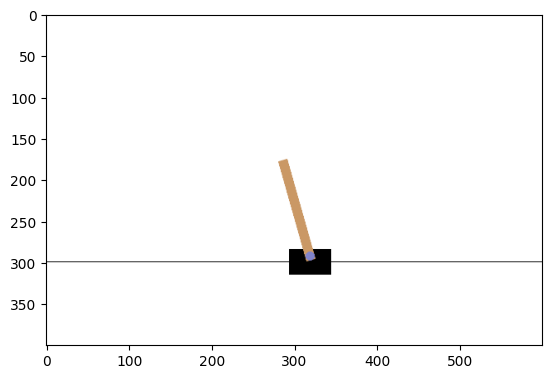

In [13]:
session.test(num_episodes=2)

### Visualization 2: After 70 batches
Continue learning for a bit from where we took off
(Check our TensorBoard first, because once you continue training it won't show prior progress)

In [ ]:
%%capture 
# run a few more batches
session.train(max_num_batches=50) 

##### The rewards in TensorBoard might already give you an indication, whether this thing is going to do better than what we achieved after a few batches in **Visualisation 1**

- Can you see an improvement in the policy?

In [ ]:
session.test(num_episodes=2)

### You can play around in this Notebook section, by changing the train() configurations above and starting at the "Initialize training session"-cell.
- Play with learning rates and gradient clipnorm
- Play with activation function and initializer
- You can also switch environment to 'MountainCarContinuous-v0' or use the Bullet version of CartPole 'CartPoleContinuousBulletEnv-v0'

#### Here is a full list of Session() arguments:
    """
    Defines a training session prior to starting training.

    env_str:                ["ContinuousCartPoleEnv" "CartPoleContinuousBulletEnv-v0" "MountainCarContinuous-v0"]
    converged_reward_limit: If mean reward over 100 episodes is >= 'converged_reward_limit' training stops
                            [NOTE: only well defined for CartPole, for every other environment set to a very high number and adjust with 'train(max_num_batches)' only]
    gradient_clipnorm:      None/float introduces gradient clipping into the update of both NN.
                            [NOTE: If set, all gradients are clipped such that their norm is <= gradient_clipnorm]
    lr_actor = 0.00002      You can set your own learning rates
    lr_critic = 0.001       You can set your own learning rates
    activation_function:    ['relu', 'mish']
    initializer:            ['normal', 'xavier']
    state_normalization:    True/False
    batch_normalization:    True/False
    specification:          string (You can add a custom add_on to the name of the session)
    use_existing_policy:    True/False
    policy:                 =None / path to dir of form 'A2C281120221423CartPole-v1_mish' relative to AppliedDeep../training_continuous/ as string
                            [NOTE: if policy is not provided, you will be asked to provide the Session-name of the policy you want to reuse 
                            (path to dir of form 'A2C281120221423CartPole-v1_mish' relative to AppliedDeep../training_continuous/ dir as string)]
    """



## III Convergence analysis and comparisson to the shared_NN implementation

Similar to the investigations made in 'REPORT_discrete.ipynb' the following experiment will show how much of an impact different main configurations (**weight-initializers**, **activation-functions** and **normalization-layers** ) have on training performance. We will additionally try for different **gradient_clipnorm** values and **learning-rates** if and once we get a feeling for which main configurations are favorable.

### On the adaptions
* **Weight-initializers**: If we manage to initialize the NN-weights in a fortunate manner right from the beginning, training might progress faster
* **Normalization-layers**: 
    * **Normalizing the input to the NN** (based on prior state experiences) the network will act solely on the variance from what it has known to be the average. This might decrease sensibility to inputs with large variance (obsversation space [-inf, inf])
* **Activation functions**: This is interesting, because different activation functions obviously return differently fine-grained information of what the input the the layer has been, however, some of them are more costly to compute than others, hence: the ideal activation has to be a compromise of both

* **gradient-clipnorm** enables us to dampen huge gradients, making for a more stable learning curve
* **learning-rate** Playing with different learning rates/ratios for actor and critic enables us to set which of the networks learns faster


The resulting policies are safed in the *'training_continuous/distinct_NN/pretrained'* folder and there convergence behaviour is visualized below

**Please note, that hyperparameters such as *batch_size*, *layer_size* etc. have not been altered.**

### Notes regardind TensorBoard
* It might again be necessary to run the block twice
* Untick the failing agents on the left bar in order to 'unsqueeze' the perfromance of those that acutally delivered fast learning results OR BETTER: choose **Settings> General> Horizontal Axis> Relative** on the right side of the DashBoard

In [ ]:
tb_pretrained = os.getcwd()+'/training_continuous/distinct_NN/pretrained/'

%tensorboard --logdir {tb_pretrained}

### Some further information and analysis on the graphs above

#### I did not save all configurations, but held on to those that can help visualize the following points:

- relu + normal initialization is most effecive
- state normalisation alone seems to have a negative affect
- **using batch normalization yields the best results, but followed by a collapse either way** (it achieved a max_reward run with total_reward=~180)
- using normalization interestingly is not helping

- The higher $\frac{lr_{critic}}{lr_{actor}}$ for the *'batch normalization activated set up'* the faster and *higher peak performance will be*
- gradient clipping seems to decrease learning speed and performance for the *'batch normalizations activated set up'*

#### Performance overall is very meager performance. However, while we see that the losses are decreasing nicely, investigation into which losses it is that are converging, does make sense. A typical run would project something like this (for $\frac{lr_{critic}}{lr_{actor}}=10$).

    """     
                                                            CRITIC LOSS         ACTOR LOSS
            Episode: 5, latest episode reward: 36.0, loss: [94.08220672607422, 9.25880241394043]
            Episode: 6, latest episode reward: 37.0, loss: [121.15396118164062, 10.626602172851562]
            Episode: 7, latest episode reward: 10.0, loss: [121.15396118164062, 10.626602172851562]
            Episode: 8, latest episode reward: 6.0, loss: [121.15396118164062, 10.626602172851562]
            ...
            Episode: 685, latest episode reward: 33.0, loss: [11.444113731384277, 0.7734909653663635]
            Episode: 686, latest episode reward: 11.0, loss: [11.444113731384277, 0.7734909653663635]
            Episode: 687, latest episode reward: 10.0, loss: [17.94942855834961, 1.7415549755096436]
            Episode: 688, latest episode reward: 10.0, loss: [17.94942855834961, 1.7415549755096436]
    """

#### So the largest part of the total_loss comes from the critic. It appears the critic does not learn very well. This would be surprising, since it is the exact same functions that make it learn as in the discrete version. (However, it has to be admitted that in the best working of the discrete case, the losses are of a similar range, while rewards are way way better)... 

#### TO SUM UP: PURE CONFUSION (There must some maldefinition of loss function but I cannot figure it out??)

## Learnings
(assuming that this implementation is in it's core functional)

- what works for the discrete case does not necessarily help in the continuous case
- the continuous case is not easy at all


## Finally the best agent's policy demonstrated for 1 episode

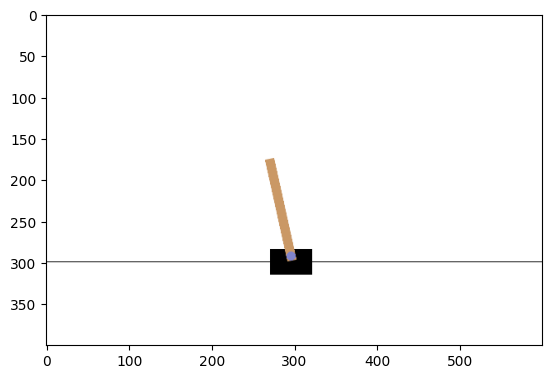

In [14]:
best_session = train.Session(converged_reward_limit=195, env_str="ContinuousCartPoleEnv", gradient_clipnorm=None, lr_actor=0.0002, lr_critic=0.001, activation_function='relu', initializer='normal',
                      specification="SHOWCASE", state_normalization=False, batch_normalization=True, use_existing_policy=True, policy="pretrained/CCartPole_relu_normal_lr_0.0002_0.001_BATCH_NORMALIZATION")
best_session.test(num_episodes=3)

### not entirely awful, but far from what we have seen in the discrete agent..

## Thanks for following this Notebook-series!